<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

2023-12-07 10:50:49.743709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 10:51:22.768444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2023-12-07 10:51:22.769142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2023-12-07 10:51:22.769163: W tensorflow/compiler/tf2tensorrt/utils/py_utils

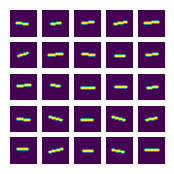

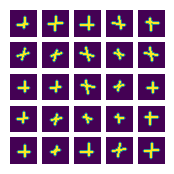

In [2]:
from scipy.ndimage import rotate
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #3202

X_text: "16+1 " = y_text: "17 "


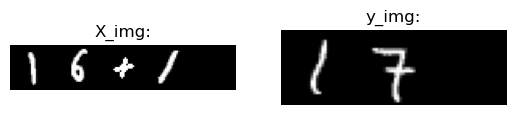

Query #1919

X_text: "9-59 " = y_text: "-50"


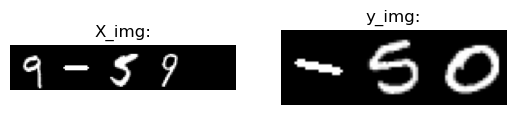

Query #1970

X_text: "9+85 " = y_text: "94 "


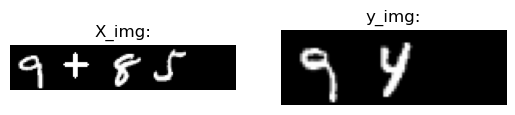

Query #8064

X_text: "40+32" = y_text: "72 "


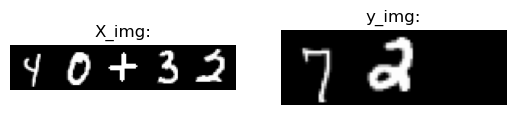

Query #8313

X_text: "41-56" = y_text: "-15"


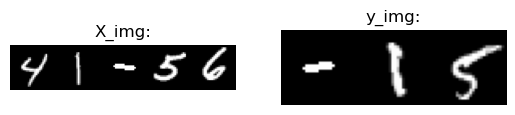

Query #1398

X_text: "6+99 " = y_text: "105"


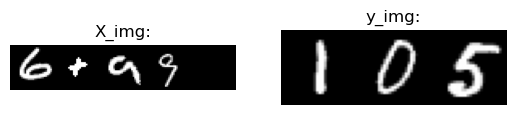

Query #2396

X_text: "11+98" = y_text: "109"


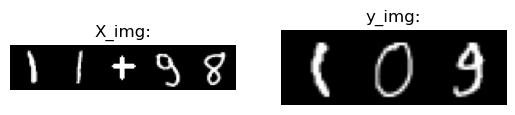

Query #2552

X_text: "12+76" = y_text: "88 "


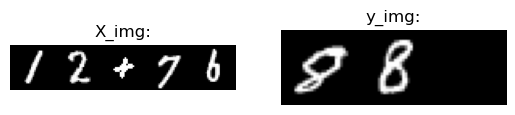

Query #4054

X_text: "20+27" = y_text: "47 "


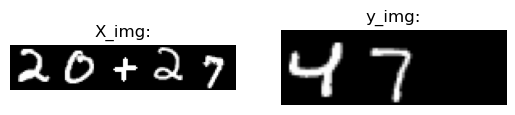

Query #5666

X_text: "28+33" = y_text: "61 "


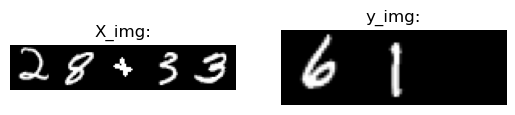

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):









---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [6]:
## Your code
from tensorflow.keras.layers import Input, ConvLSTM2D, Dense, TimeDistributed, Flatten, Dropout, MaxPooling2D

def build_image2text():
    input_shape = (5, 28, 28, 1)
    vocab_size = len(unique_characters)
    sequence_length = 3
    
    # Define the model
    model = tf.keras.Sequential()

    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    
    # Merge time steps using LSTM layers
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=False))
    
    model.add(RepeatVector(3))
    
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    
    # Dense layer for output
    model.add(Dense(256, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

image2text = build_image2text()
image2text.summary()





2023-12-07 10:52:49.588527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/s4014049/.local/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64
2023-12-07 10:52:49.588583: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-12-07 10:52:49.589138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 26, 26, 32)    320       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 13, 13, 32)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 5408)          0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 5, 256)            5800960   
                                                                 
 lstm_1 (LSTM)               (None, 5, 256)            525312    
                                                        

In [7]:
#Train Model
X_train, X_test, y_train, y_test = train_test_split(X_img, y_text, test_size=0.2)

y_train_onehot = encode_labels(y_train)

epochs = 100

image2text.fit(X_train, y_train_onehot, epochs=epochs, batch_size=16)


Epoch 1/100
1000/1000 [==============================] - 122s 109ms/step - loss: 2.0337 - accuracy: 0.3367
Epoch 2/100
1000/1000 [==============================] - 106s 106ms/step - loss: 1.7176 - accuracy: 0.4102
Epoch 3/100
1000/1000 [==============================] - 113s 113ms/step - loss: 1.4581 - accuracy: 0.4712
Epoch 4/100
1000/1000 [==============================] - 114s 114ms/step - loss: 1.3141 - accuracy: 0.5184
Epoch 5/100
1000/1000 [==============================] - 105s 105ms/step - loss: 1.2170 - accuracy: 0.5500
Epoch 6/100
1000/1000 [==============================] - 111s 111ms/step - loss: 1.1337 - accuracy: 0.5741
Epoch 7/100
1000/1000 [==============================] - 112s 112ms/step - loss: 1.0739 - accuracy: 0.5959
Epoch 8/100
1000/1000 [==============================] - 112s 112ms/step - loss: 1.0299 - accuracy: 0.6089
Epoch 9/100
1000/1000 [==============================] - 111s 111ms/step - loss: 0.9877 - accuracy: 0.6253
Epoch 10/100
1000/1000 [=============

In [8]:
#Test Model
y_test_onehot = encode_labels(y_test)
evaluation = image2text.evaluate(X_test, y_test_onehot)

print("Test Loss: ", evaluation[0])
print("Test Accuracy: ", evaluation[1])



125/125 [==============================] - 10s 45ms/step - loss: 0.5577 - accuracy: 0.8919
Test Loss:  0.5577012300491333
Test Accuracy:  0.8919166922569275


---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
# Your code










---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

(10000,) (10000, 5, 28, 28) (10000,) (10000, 5, 28, 28)
Query #1713

X_text: "17*13" = y_text: "221  "


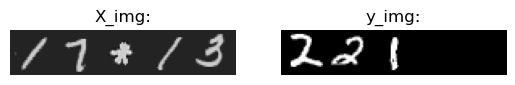

Query #4004

X_text: "40*4 " = y_text: "160  "


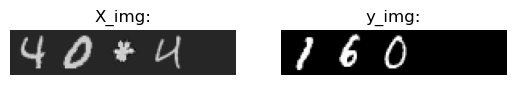

Query #7928

X_text: "79*28" = y_text: "2212 "


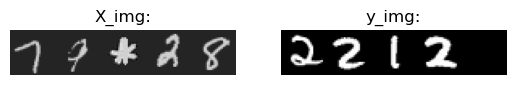

Query #5619

X_text: "56*19" = y_text: "1064 "


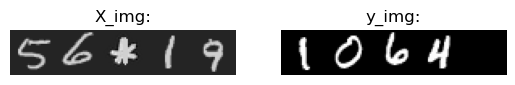

Query #5750

X_text: "57*50" = y_text: "2850 "


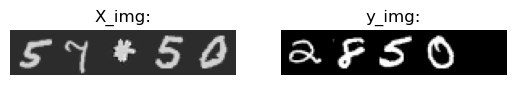

Query #7305

X_text: "73*5 " = y_text: "365  "


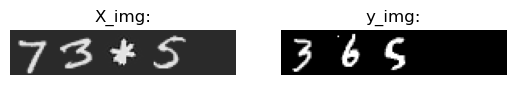

Query #5217

X_text: "52*17" = y_text: "884  "


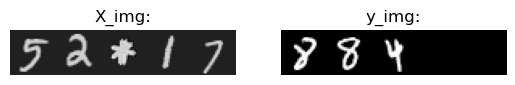

Query #5878

X_text: "58*78" = y_text: "4524 "


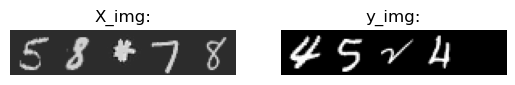

Query #308

X_text: "3*8  " = y_text: "24   "


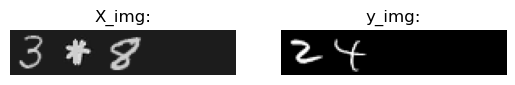

Query #3566

X_text: "35*66" = y_text: "2310 "


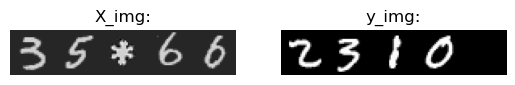

In [7]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

In [47]:
## Your code

def build_image2text_m():
    input_shape = (5, 28, 28, 1)
    vocab_size = len(unique_characters)
    
    # Define the model
    model = tf.keras.Sequential()

    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    
    # Merge time steps using LSTM layers
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(256, return_sequences=False))
    
    model.add(RepeatVector(5))
    
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    
    # Dense layer for output
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


image2text_m = build_image2text_m()
image2text_m.summary()








Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_62 (TimeDi  (None, 5, 26, 26, 32)    320       
 stributed)                                                      
                                                                 
 time_distributed_63 (TimeDi  (None, 5, 13, 13, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, 5, 11, 11, 32)    9248      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 5, 5, 5, 32)      0         
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 5, 800)         

In [50]:
#Train Model
X_train, X_test, y_train, y_test = train_test_split(X_img, y_text, test_size=0.2)

y_train_onehot = encode_labels(y_train)

epochs = 100

image2text_m.fit(X_train, y_train_onehot, epochs=epochs, batch_size=16)

Epoch 1/100
500/500 [==============================] - 49s 73ms/step - loss: 0.5562 - accuracy: 0.8302
Epoch 2/100
500/500 [==============================] - 38s 76ms/step - loss: 0.3411 - accuracy: 0.8867
Epoch 3/100
500/500 [==============================] - 38s 77ms/step - loss: 0.2944 - accuracy: 0.9021
Epoch 4/100
500/500 [==============================] - 36s 73ms/step - loss: 0.3156 - accuracy: 0.8971
Epoch 5/100
500/500 [==============================] - 38s 77ms/step - loss: 0.2661 - accuracy: 0.9118
Epoch 6/100
500/500 [==============================] - 38s 77ms/step - loss: 0.2435 - accuracy: 0.9177
Epoch 7/100
500/500 [==============================] - 37s 75ms/step - loss: 0.2153 - accuracy: 0.9263
Epoch 8/100
500/500 [==============================] - 38s 76ms/step - loss: 0.2120 - accuracy: 0.9279
Epoch 9/100
500/500 [==============================] - 36s 72ms/step - loss: 0.2172 - accuracy: 0.9261
Epoch 10/100
500/500 [==============================] - 35s 70ms/step - l

In [51]:
#Test Model
y_test_onehot = encode_labels(y_test)
evaluation = image2text_m.evaluate(X_test, y_test_onehot)

print("Test Loss: ", evaluation[0])
print("Test Accuracy: ", evaluation[1])

63/63 [==============================] - 2s 31ms/step - loss: 0.6140 - accuracy: 0.8826
Test Loss:  0.6140377521514893
Test Accuracy:  0.8826000094413757
